# Task

Med målsättningen att analysera bostadsdata (housing) ska vi bygga en fungerande modell som kan uppskatta bostadspriser och samtidigt motivera våra designval.

**Uppgiften i korthet:**

1. Ladda in datat och ge en snabb överblick (storlek, exempelrader, saknade värden).
2. Göra en enkel EDA med några centrala översikter/grafer (t.ex. korrelation och en spridningsplot).
3. Förbereda data med en reproducerbar *pipeline* (imputering, skalning av numeriskt, one-hot-encoding av kategoriskt).
4. Dela data i train/test.
5. Träna minst två modeller (t.ex. Linjär Regression och Random Forest), jämför på testdata.
6. Om trädmodell används: visa *feature importances*.
7. Sammanfatta kort vad som påverkade priset mest och hur bra modellen presterade.

> **Tips:** Kör hela notebooken uppifrån och ner så genereras alla figurer och tabeller.


In [7]:
# ===== Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math

pd.set_option("display.max_columns", 200)


# EDA

In [8]:
# Läs in data (byt till lokal sökväg om du kör filen lokalt)
DATA_URL = "https://raw.githubusercontent.com/AntonioPrgomet/ds24_ml/main/kunskapskontroll_1/data/housing.csv"
housing = pd.read_csv(DATA_URL)

# Snabb titt
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.shape

(20640, 10)

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing.describe().T


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [12]:
housing.isna().sum().sort_values(ascending=False)

total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [13]:
# Lista kategoriska kolumner (om några) och visa toppvärden
cat_cols_overview = housing.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols_overview, {c: housing[c].nunique() for c in cat_cols_overview}

(['ocean_proximity'], {'ocean_proximity': 5})

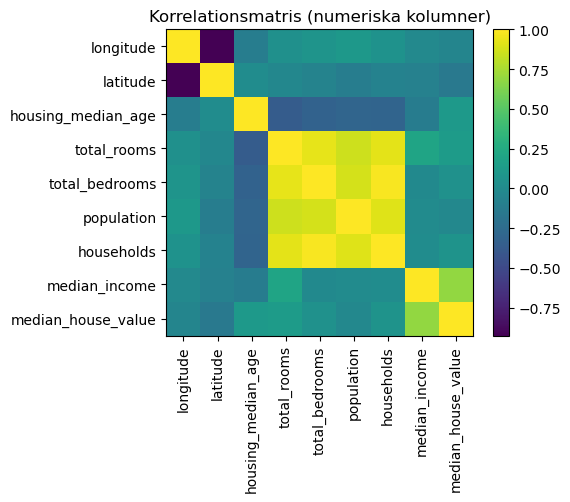

In [14]:
# Korrelation mot målvariabeln (antar 'median_house_value' som target om den finns)
target = "median_house_value" if "median_house_value" in housing.columns else None

num_cols_all = housing.select_dtypes(include=[np.number]).columns.tolist()
if target and target in num_cols_all:
    corr = housing[num_cols_all].corr(numeric_only=True)
    # En enkel heatmap med matplotlib (ingen seaborn)
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(corr, interpolation='nearest')
    ax.set_xticks(range(len(num_cols_all)))
    ax.set_yticks(range(len(num_cols_all)))
    ax.set_xticklabels(num_cols_all, rotation=90)
    ax.set_yticklabels(num_cols_all)
    fig.colorbar(cax)
    ax.set_title("Korrelationsmatris (numeriska kolumner)")
    plt.tight_layout()
    plt.show()

    corr_target = corr[target].drop(labels=[target]).sort_values(ascending=False)
    corr_target.head(10)
else:
    print("Hittade inte numerisk target 'median_house_value' – hoppar över korrelationsmatris.")


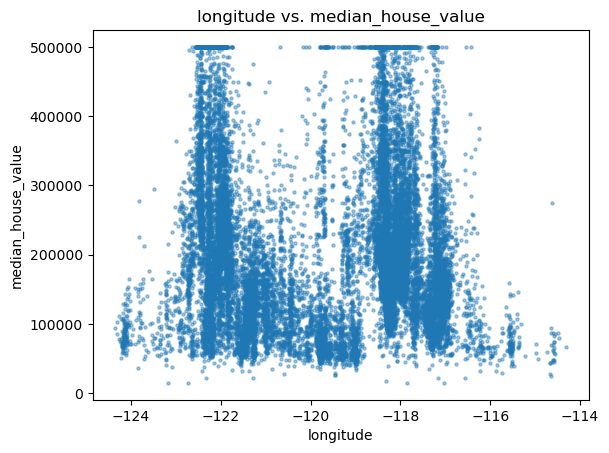

In [15]:
# En enkel scatter: longitude vs. median_house_value (om kolumnerna finns)
if {"longitude", "median_house_value"}.issubset(housing.columns):
    plt.figure()
    plt.scatter(housing["longitude"], housing["median_house_value"], s=5, alpha=0.4)
    plt.xlabel("longitude")
    plt.ylabel("median_house_value")
    plt.title("longitude vs. median_house_value")
    plt.show()


# Preparing data

In [16]:
# Definiera target och features
if target is None:
    # fallback om datasetet har annan target-kolumn
    candidates = [c for c in housing.columns if any(k in c.lower() for k in ["price","value","sale","target"])]
    target = candidates[0] if candidates else housing.columns[-1]

features = [c for c in housing.columns if c != target]

X = housing[features].copy()
y = housing[target].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Pipelines
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)

(16512, 4128)

# Models

In [17]:
def fit_and_eval(model, name):
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return {"name": name, "pipe": pipe, "rmse": rmse, "r2": r2}

res_lr = fit_and_eval(LinearRegression(), "Linear Regression")
res_rf = fit_and_eval(RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1), "Random Forest")

for res in [res_lr, res_rf]:
    print(f"{res['name']:<18}  RMSE: {res['rmse']:,.0f}   R²: {res['r2']:.3f}")

best = min([res_lr, res_rf], key=lambda r: r["rmse"])
best_model_name = best["name"]
best_rmse = best["rmse"]
best_r2 = best["r2"]
best_pipe = best["pipe"]

print('\nBest model:', best_model_name)
print(f"RMSE ≈ {best_rmse:,.0f} | R² ≈ {best_r2:.3f}")

Linear Regression   RMSE: 70,059   R²: 0.625
Random Forest       RMSE: 48,722   R²: 0.819

Best model: Random Forest
RMSE ≈ 48,722 | R² ≈ 0.819


## Feature importances (om Random Forest vann)

median_income                 0.490014
ocean_proximity_INLAND        0.141376
longitude                     0.106136
latitude                      0.101165
housing_median_age            0.052426
population                    0.032463
total_rooms                   0.023693
total_bedrooms                0.023681
households                    0.018089
ocean_proximity_NEAR OCEAN    0.006418
dtype: float64

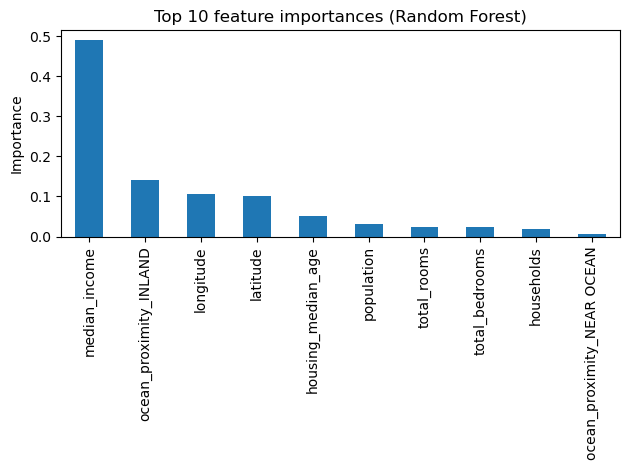

In [18]:
if best_model_name == "Random Forest":
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"] if len(cat_cols) else None
    num_names = num_cols
    cat_names = list(ohe.get_feature_names_out(cat_cols)) if ohe is not None else []
    feat_names = num_names + cat_names

    importances = best_pipe.named_steps["model"].feature_importances_
    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(10)
    display(imp)

    plt.figure()
    imp.plot(kind="bar")
    plt.title("Top 10 feature importances (Random Forest)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


# Conclusion

- En enkel, reproducerbar pipeline etablerades (imputering, skalning, one-hot-encoding).
- Två modeller jämfördes: **Linear Regression** och **Random Forest**.
- Bästa modellens prestanda (RMSE och R²) rapporteras i cellen ovan.
- Enligt trädmodellen (om vald) framgår vilka variabler som bidrar mest till prediktionen.

**Vidare förbättringar:** hyperparametertuning (Grid/Random/Optuna), korsvalidering (Cross-Validation) samt utökad feature engineering.
